# SkyCoord Testing
Switch to using skycoords for everything. Test an example here.

In [18]:
import os
import subprocess

import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from sunpy.sun import constants
from sunpy.map import Map
from sunpy.coordinates import Helioprojective, HeliographicStonyhurst
import yt

import synthesizAR
import synthesizAR.extrapolate
from synthesizAR.interfaces.ebtel import EbtelInterface,RandomNanoflares
from synthesizAR.instruments import InstrumentSDOAIA
#from synthesizAR.util import heeq_to_hcc_coord

%matplotlib inline

In [28]:
yt.funcs.mylog.setLevel(50)
yt.config.ytcfg.set('yt', 'suppressStreamLogging','True')

In [29]:
yt.config.ytcfg.get('yt', 'suppressStreamLogging')

'True'

Create a synthetic magnetogram and extrapolate a field from it.

In [30]:
shape = [ 50, 50] * u.pixel
obs = SkyCoord(lon=0.*u.deg,lat=0.*u.deg,radius=const.au,frame=HeliographicStonyhurst)
blc = SkyCoord(-50 * u.arcsec, -50 * u.arcsec,frame=Helioprojective(observer=obs))
trc = SkyCoord(50 * u.arcsec, 50 * u.arcsec, frame=Helioprojective(observer=obs))
centers = SkyCoord([15,-15,]*u.arcsec,[0, 0,]*u.arcsec,frame=Helioprojective(observer=obs))
sigmas = u.Quantity([[5,5],[5,5],],'arcsec')
amplitudes = u.Quantity([1e3, -1e3,], 'Gauss')
magnetogram = synthesizAR.extrapolate.synthetic_magnetogram(blc, trc, shape, centers, sigmas, amplitudes, observer=obs)

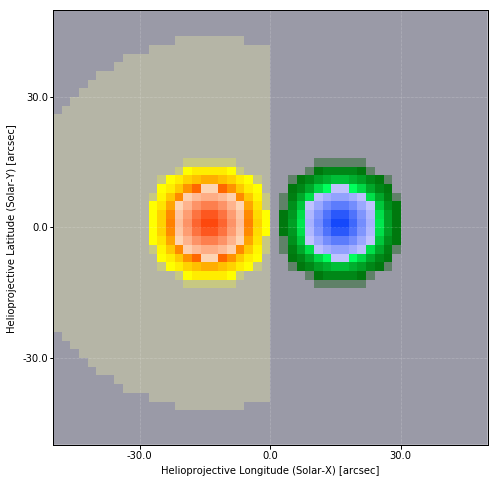

In [31]:
plt.figure(figsize=(8,8))
magnetogram.plot(cmap='hmimag',vmin=-1.5e3,vmax=1.5e3,title=False)

In [32]:
shape_z = 50*u.pixel
width_z = (magnetogram.scale.axis1 * shape_z).to(u.radian).value * magnetogram.dsun
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram,width_z,shape_z)

In [33]:
B_field = extrapolator.extrapolate()

Trace a bunch of fieldlines and plot them.

In [34]:
fieldlines = extrapolator.trace_fieldlines(B_field, 100,)

FloatProgress(value=0.0)

Create an active region object from a magnetogram and a list of fieldlines (`SkyCoord` + `Quantity`)

In [16]:
active_region = synthesizAR.Field(magnetogram,fieldlines)

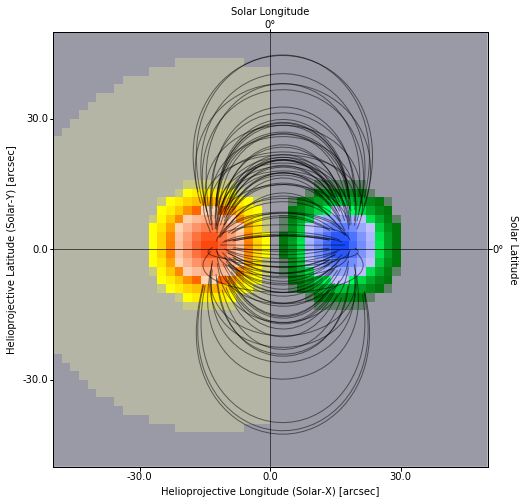

In [17]:
active_region.peek(line_frequency=1)

Look, all the loop coordinates are SkyCoord objects!

Next, build a heating model to heat each of the fieldlines

In [10]:
heating_model = RandomNanoflares(200*u.s,0.3)

Now, setup the hydrodynamic model.

In [13]:
base_config = synthesizAR.util.read_xml(
    '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config['total_time'] = 1e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True

In [14]:
ebtel = EbtelInterface(base_config,heating_model,
                       '/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/hydro_config',
                       '/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/hydro_results')

And configure and run the loop simulations.

In [15]:
active_region.configure_loop_simulations(ebtel,)

FloatProgress(value=0.0)

In [17]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/Users/willbarnes/Documents/work/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [18]:
for loop in active_region.loops:
    ebtel_runner(loop)

In [19]:
active_region.load_loop_simulations(
    ebtel,
    '/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/loop_parameters.h5')

FloatProgress(value=0.0)

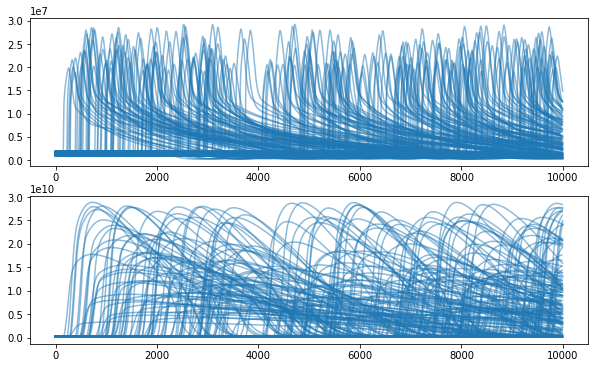

In [21]:
fig,ax = plt.subplots(2,1,figsize=(10,6))
for l in active_region.loops:
    ax[0].plot(l.time,l.electron_temperature[:,0],'C0',alpha=0.5)
    ax[1].plot(l.time,l.density[:,0],'C0',alpha=0.5)

You can easily roundtrip the active region object to disk

In [22]:
active_region.save('/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/field_checkpoint/')

In [2]:
active_region = synthesizAR.Field.restore(
    '/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/field_checkpoint/')

Now create the instrument and observer. The observing time can be any interval inside our simulation interval (0-5000 s).

In [29]:
aia = InstrumentSDOAIA([2000,2010]*u.s,active_region.magnetogram.observer_coordinate)

The observer object coordinates the "observation" of our synthetic AR for multiple instruments. This maybe removed entirely in the future in favor of just using the instrument objects for everything.

In [30]:
observer = synthesizAR.Observer(active_region,[aia],)

In [31]:
observer.build_detector_files('/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/',0.1*u.Mm)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [6]:
observer.flatten_detector_counts()

In [32]:
observer.bin_detector_counts('/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/')

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


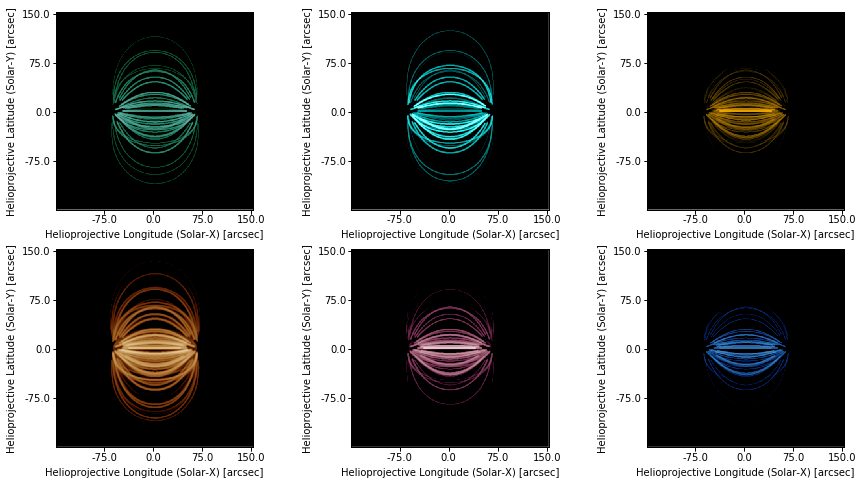

In [33]:
fig = plt.figure(figsize=(15,8))
for i,c in enumerate(aia.channels):
    m = Map(f'/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/SDO_AIA/{c["name"]}/map_t000000.fits')
    ax = fig.add_subplot(2,3,i+1,projection=m)
    m.plot(axes=ax,title=False,
           norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1,vmax=1e3))
    ax.grid(alpha=0)

We can also change the viewing angle by defining a new SkyCoord object. For example, we can define an off-observer  

In [63]:
observer_coord = SkyCoord(lon=-90*u.deg,lat=0*u.deg,radius=active_region.magnetogram.observer_coordinate.radius,
                    frame='heliographic_stonyhurst')

In [64]:
aia.observer_coordinate = observer_coord

In [65]:
observer.bin_detector_counts('/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/off_limb')

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


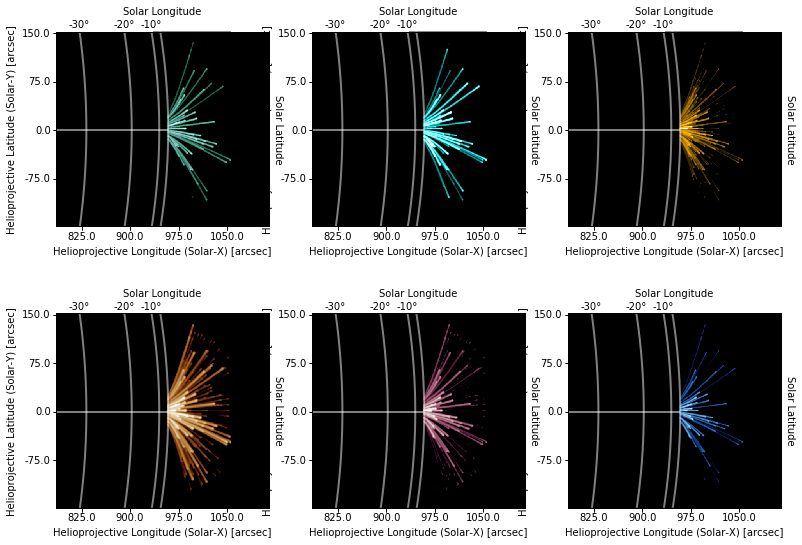

In [112]:
fig = plt.figure(figsize=(13,9.5))
for i,c in enumerate(aia.channels):
    m = Map(f'/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/off_limb/SDO_AIA/{c["name"]}/map_t000000.fits')
    ax = fig.add_subplot(2,3,i+1,projection=m)
    m.plot(axes=ax,title=False,
           norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1,vmax=1e3))
    ax.grid(alpha=0)
    #m.draw_limb(color='w',lw=2,axes=ax)
    m.draw_grid(axes=ax,color='w',grid_spacing=10*u.deg,lw=2)
    ax.plot_coord(
        SkyCoord(Tx=800*u.arcsec,Ty=0*u.arcsec,frame=m.coordinate_frame),
        color='k',marker='o',ls=None,
    )
    ax.plot_coord(
        SkyCoord(Tx=1100*u.arcsec,Ty=0*u.arcsec,frame=m.coordinate_frame),
        color='k',marker='o',ls=None,
    )
    ax.set_facecolor('k')

Or one that looks down the arcade of loops.

In [77]:
observer_coord = SkyCoord(lon=0*u.deg,lat=-75*u.deg,radius=active_region.magnetogram.observer_coordinate.radius,
                    frame='heliographic_stonyhurst')

In [78]:
aia.observer_coordinate = observer_coord

In [79]:
observer.bin_detector_counts('/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/arcade')

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


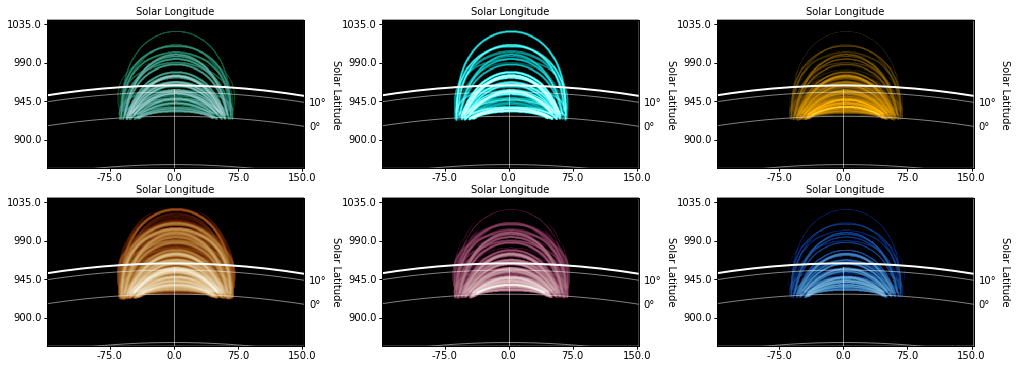

In [80]:
fig = plt.figure(figsize=(17,6))
for i,c in enumerate(aia.channels):
    m = Map(f'/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/arcade/SDO_AIA/{c["name"]}/map_t000000.fits')
    ax = fig.add_subplot(2,3,i+1,projection=m)
    m.plot(axes=ax,title=False,annotate=False,
           norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1,vmax=1e3))
    ax.grid(alpha=0)
    m.draw_limb(color='w',lw=2,axes=ax)
    m.draw_grid(axes=ax,color='w',grid_spacing=10*u.deg,lw=1)

In [106]:
foobar = synthesizAR.Loop(
    'foo_bar',
    SkyCoord(Tx=[-50,50]*u.arcsec, Ty=[0,0]*u.arcsec,
             frame=sunpy.coordinates.Helioprojective(observer=active_region.magnetogram.observer_coordinate)),
    u.Quantity([100,100],'Gauss')
)

In [108]:
foobar.coordinates

<SkyCoord (HeliographicStonyhurst: obstime=None): (x, y, z) in km
    [(694570.74233051, -36095.17919791, 0.),
     (694570.74233051,  36095.17919791, 0.)]>

In [113]:
constants.au

<<class 'astropy.constants.iau2012.IAU2012'> name='Astronomical Unit' value=149597870700.0 uncertainty=0.0 unit='m' reference='IAU 2012 Resolution B2'>

In [114]:
const.au

<<class 'astropy.constants.iau2015.IAU2015'> name='Astronomical Unit' value=149597870700.0 uncertainty=0.0 unit='m' reference='IAU 2012 Resolution B2'>

In [116]:
foobar.coordinates.frame

<HeliographicStonyhurst Coordinate (obstime=None): (x, y, z) in km
    [(694570.74233051, -36095.17919791, 0.),
     (694570.74233051,  36095.17919791, 0.)]>

In [117]:
active_region

synthesizAR Active Region Object
------------------------
Number of loops: 250
Simulation Type: 
Magnetogram Info:
-----------------
SunPy Map
---------
Observatory:		 synthetic magnetic imager
Instrument:		 synthetic magnetic imager
Detector:		 synthetic_magnetic_imager
Measurement:		 0.0
Wavelength:		 0.0
Observation Date:	 2018-05-21 15:10:42
Exposure Time:		 0.000000 s
Dimension:		 [75. 75.] pix
Coordinate System:	 helioprojective
Scale:			 [4. 4.] arcsec / pix
Reference Pixel:	 [38. 38.] pix
Reference Coord:	 [0. 0.] arcsec

array([[-2.05322585e-26, -8.97971098e-26, -3.65767262e-25, ...,
         1.38759952e-24,  3.65767262e-25,  8.97971098e-26],
       [-2.85176517e-25, -1.24720946e-24, -5.08021237e-24, ...,
         1.92726386e-23,  5.08021237e-24,  1.24720946e-24],
       [-3.68899132e-24, -1.61336737e-23, -6.57166992e-23, ...,
         2.49307332e-22,  6.57166992e-23,  1.61336737e-23],
       ...,
       [-4.44445327e-23, -1.94376599e-22, -7.91747047e-22, ...,
         3.00362

In [118]:
ar2 = synthesizAR.Field.restore('/Users/willbarnes/Desktop/synthesizar_coords_refactor_testing/field_checkpoint/')

In [121]:
ar2.loops[0].coordinates == active_region.loops[0].coordinates

False

In [132]:
ar2.loops[0].coordinates

<SkyCoord (HeliographicStonyhurst: obstime=None): (x, y, z) in cm
    [(6.96193288e+10,  3.32129161e+09, 8.87011384e+08),
     (6.96743640e+10,  3.25388783e+09, 9.18549252e+08),
     (6.97266356e+10,  3.18453492e+09, 9.50558927e+08),
     (6.97765298e+10,  3.11360588e+09, 9.82918211e+08),
     (6.98253903e+10,  3.04200151e+09, 1.01536993e+09),
     (6.98732130e+10,  2.96968077e+09, 1.04777908e+09),
     (6.99201221e+10,  2.89665448e+09, 1.07994013e+09),
     (6.99661007e+10,  2.82295941e+09, 1.11191914e+09),
     (7.00108235e+10,  2.74849943e+09, 1.14390587e+09),
     (7.00541115e+10,  2.67314731e+09, 1.17577579e+09),
     (7.00957404e+10,  2.59670671e+09, 1.20726048e+09),
     (7.01359946e+10,  2.51938170e+09, 1.23837400e+09),
     (7.01749741e+10,  2.44127031e+09, 1.26914350e+09),
     (7.02125212e+10,  2.36228235e+09, 1.29945201e+09),
     (7.02484722e+10,  2.28234283e+09, 1.32919589e+09),
     (7.02831710e+10,  2.20167621e+09, 1.35846156e+09),
     (7.03165891e+10,  2.12027213e+09,

In [133]:
active_region.loops[0].coordinates

<SkyCoord (HeliographicStonyhurst: obstime=None): (x, y, z) in cm
    [(6.96193288e+10,  3.32129161e+09, 8.87011384e+08),
     (6.96743640e+10,  3.25388783e+09, 9.18549252e+08),
     (6.97266356e+10,  3.18453492e+09, 9.50558927e+08),
     (6.97765298e+10,  3.11360588e+09, 9.82918211e+08),
     (6.98253903e+10,  3.04200151e+09, 1.01536993e+09),
     (6.98732130e+10,  2.96968077e+09, 1.04777908e+09),
     (6.99201221e+10,  2.89665448e+09, 1.07994013e+09),
     (6.99661007e+10,  2.82295941e+09, 1.11191914e+09),
     (7.00108235e+10,  2.74849943e+09, 1.14390587e+09),
     (7.00541115e+10,  2.67314731e+09, 1.17577579e+09),
     (7.00957404e+10,  2.59670671e+09, 1.20726048e+09),
     (7.01359946e+10,  2.51938170e+09, 1.23837400e+09),
     (7.01749741e+10,  2.44127031e+09, 1.26914350e+09),
     (7.02125212e+10,  2.36228235e+09, 1.29945201e+09),
     (7.02484722e+10,  2.28234283e+09, 1.32919589e+09),
     (7.02831710e+10,  2.20167621e+09, 1.35846156e+09),
     (7.03165891e+10,  2.12027213e+09,

In [136]:
np.all(((ar2.loops[0].coordinates.cartesian.xyz - active_region.loops[0].coordinates.cartesian.xyz).value) == 0.)

True

In [138]:
np.isclose(ar2.loops[0].coordinates.cartesian.xyz.value, active_region.loops[0].coordinates.cartesian.xyz.value,
           atol=0, rtol=1e-9)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  Tru